In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from sklearn.manifold import MDS
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [3]:
# Стратегии работы с дисбалансом классов
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks 
from imblearn.combine import SMOTETomek

In [4]:
import pickle # для сохранения файлов с моделями

In [5]:
# Обучение моделей
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline, make_pipeline

In [6]:
# import lightgbm as lgb
from lightgbm import LGBMClassifier
from linearboost import LinearBoostClassifier

# Подготовка данных

### References

<b>Data</b>
- Ссылка на датасет в Kaggle: https://www.kaggle.com/datasets/annantkumarsingh/health-insurance-cross-sell-prediction-data/discussion/516324
- Ссылка на источник на GitHub-e: https://github.com/ankit986/HEALTH-INSURANCE-CROSS-SELL-PREDICTION

<b>Литература</b>
- Ссылка на статью: https://medium.com/data-science/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a
- Ссылка на пример на Kaggle: https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset#7.-Baseline-(no-oversampling)

### Описание данных
| Название признака | Тип | Описание  |
| :------- | :------ | :------- |
|id |числовой|Уникальный идентификатор клиента|
|Age|числовой|Возраст клиента|
|Gender|бинарный|Пол клиента|
|Driving_License|бинарный|0 для клиентов, не имеющих водительских прав, 1 для клиентов, имеющих водительские права|
|Region_Code|номинальный|Уникальный код региона клиента|
|Previously_Insured|бинарный|0 для клиентов, не имеющих страховки на транспортное средство, 1 для клиентов, имеющих страховку на транспортное средство|
|Vehicle_Age|номинальный|Возраст транспортного средства|
|Vehicle_Damage|бинарный|1: Клиент получил повреждение своего автомобиля в прошлом. 0: Клиент не получал повреждения своего автомобиля в прошлом|
|Annual_Premium|числовой|Сумма, которую клиент должен заплатить в качестве премии в течение года|
|Policy_Sales_Channel|номинальный|Анонимизированный код канала взаимодействия с клиентом, т. е. различные агенты, по почте, по телефону, лично и т. д.|
|Vintage|числовой|Количество дней, в течение которых клиент связан с компанией|
|Response (таргет)|бинарный|1 для заинтересованного клиента, 0 для незаинтересованного клиента|

In [7]:
# Загрузка датасета
df = pd.read_csv('train.csv')

In [8]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [9]:
df.shape

(11504798, 12)

In [10]:
# Выделяем обучающий набор и валидацию
# test = df.tail(df.shape[0]-5000000) # валидация
# test.to_csv('test_data.csv')

df = df.head(5000000)
df.shape

(5000000, 12)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 457.8+ MB


In [12]:
# Подсчет пропущенных значений
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

В наборе данных не наблюдаются пропущенные значения.

In [13]:
# Сразу отбросим столбец id, т.к. он никакую полезную информацию о клиенте не несет
print('Число уникальных значений признака id:', len(df.id.unique()))
df = df.drop(columns = ['id'])

Число уникальных значений признака id: 5000000


In [14]:
# Описательная статистика признаков в числовом формате
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,3.838755e+01,9.980264e-01,2.641528e+01,4.628668e-01,3.046855e+04,1.124040e+02,1.639189e+02,1.230562e-01
std,1.499676e+01,4.438136e-02,1.298993e+01,4.986193e-01,1.647620e+04,5.404819e+01,7.997458e+01,3.285017e-01
min,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527900e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945400e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [15]:
# Описательная статистика категориальных признаков
df.describe(include = ['O'])

,Gender,Vehicle_Age,Vehicle_Damage
count,5000000,5000000,5000000
unique,2,3,2
top,Male,1-2 Year,Yes
freq,2707018,2600661,2514240


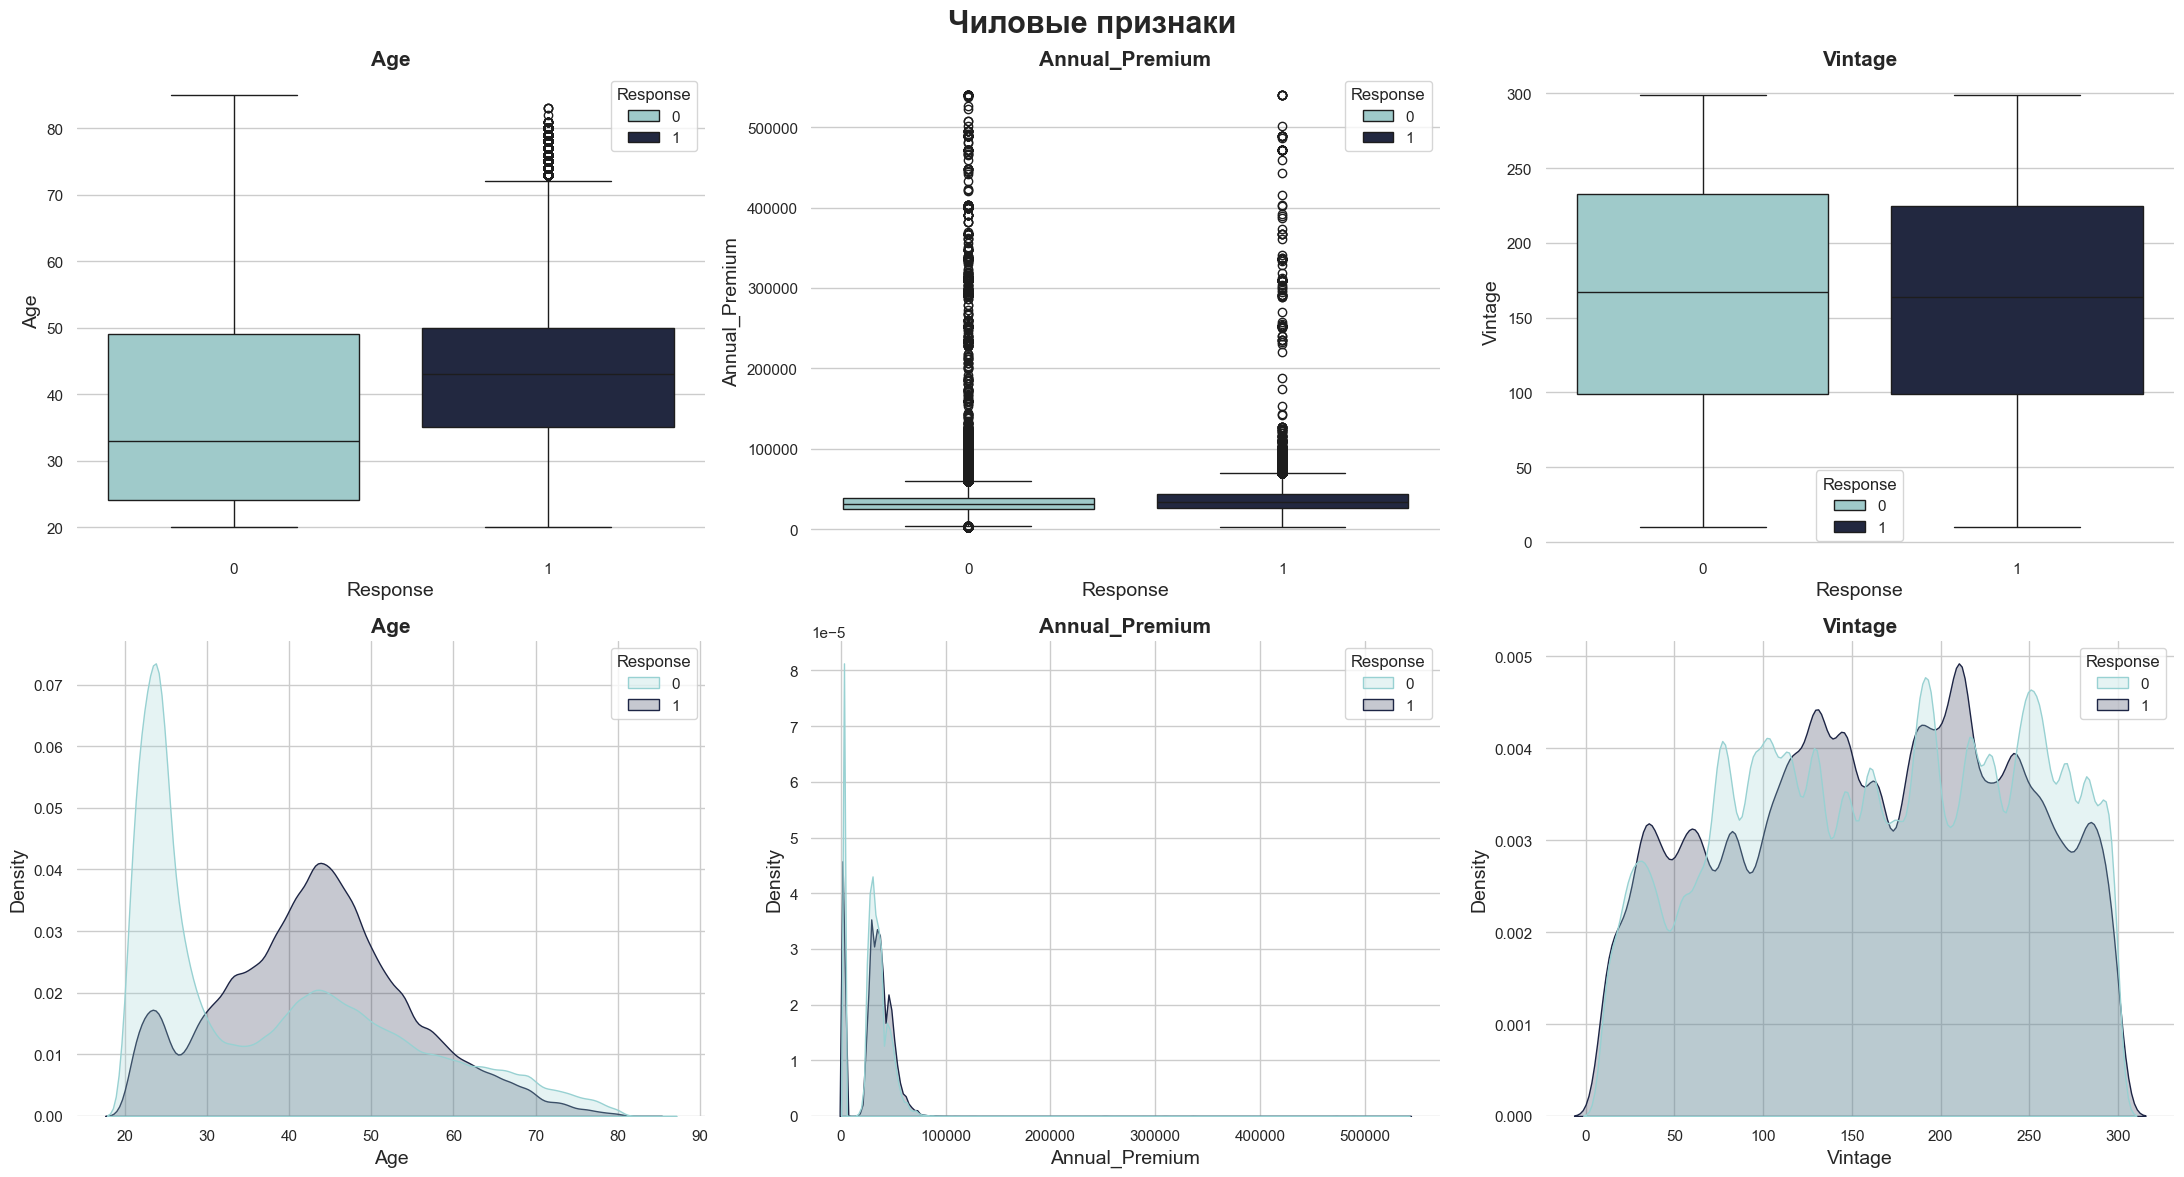

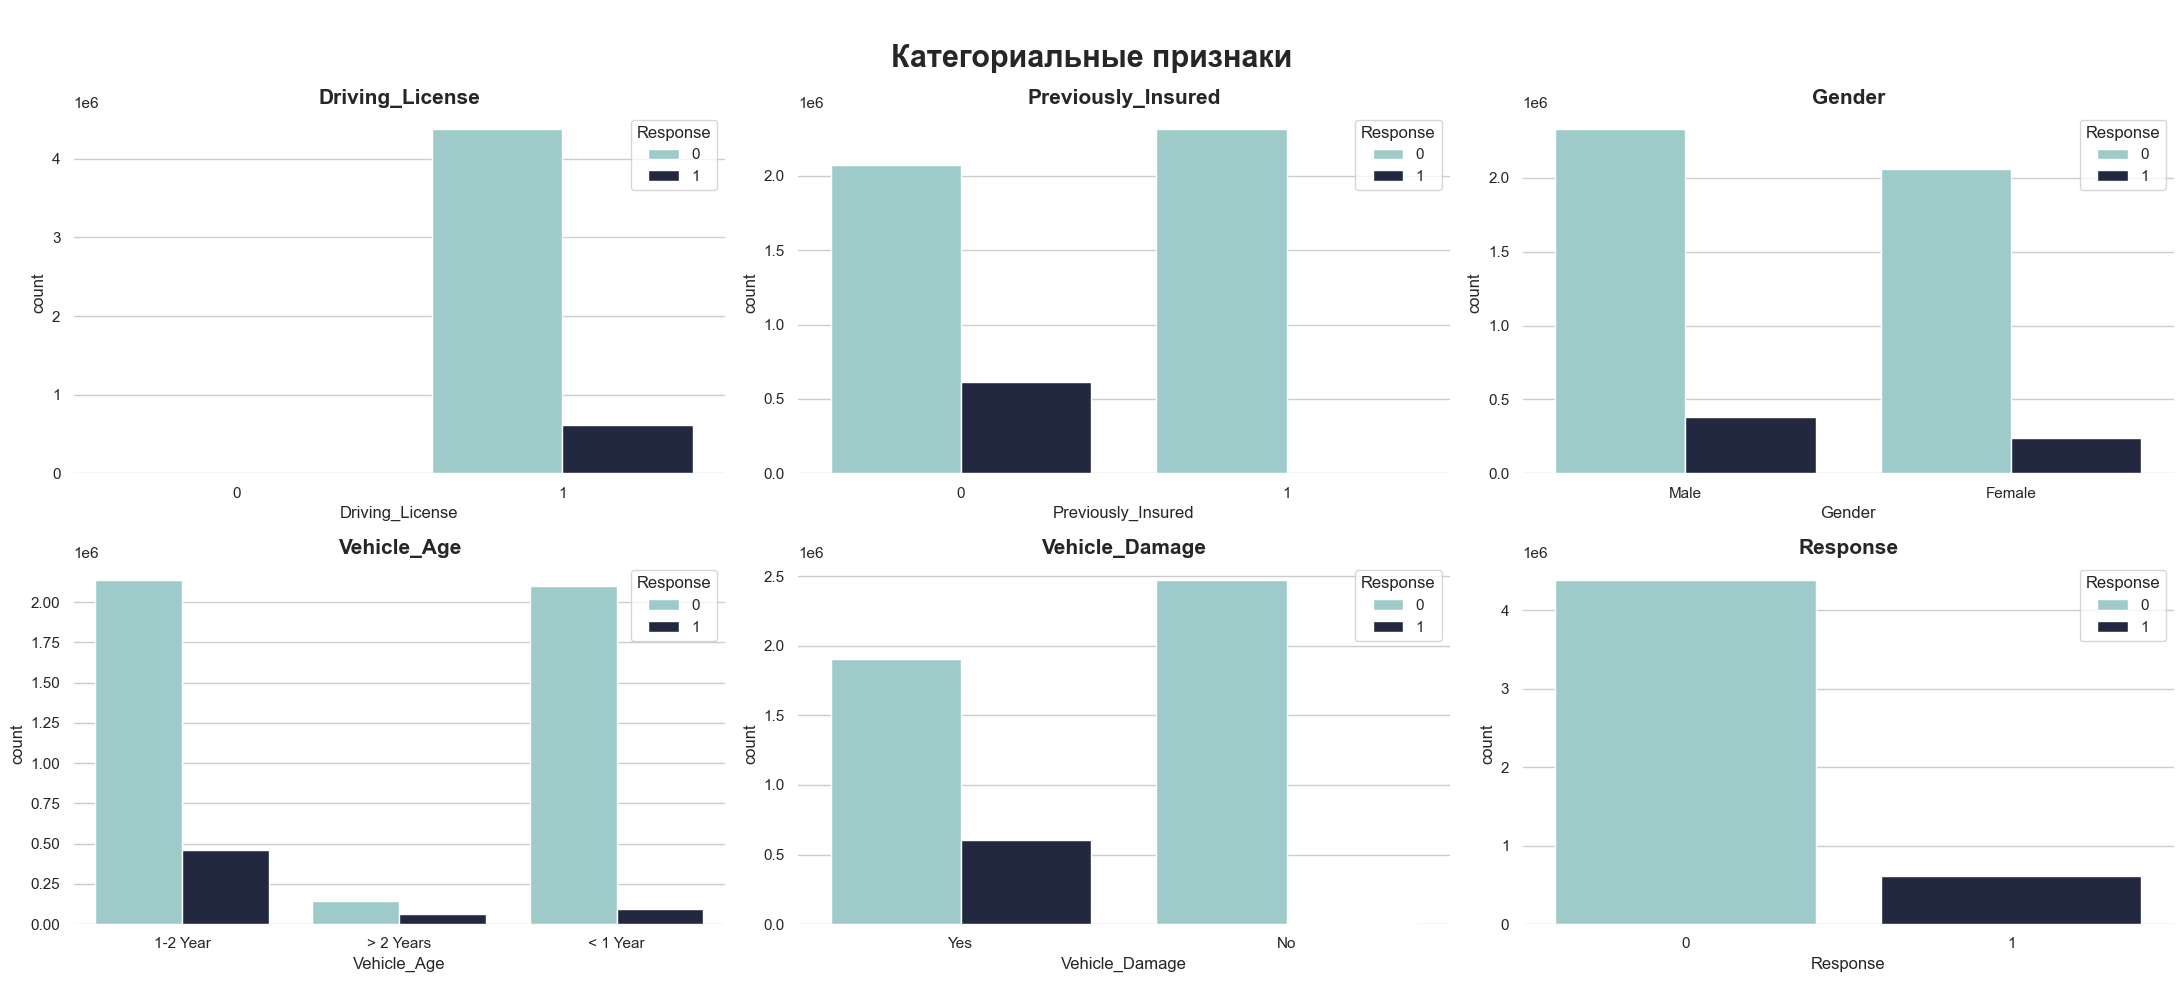

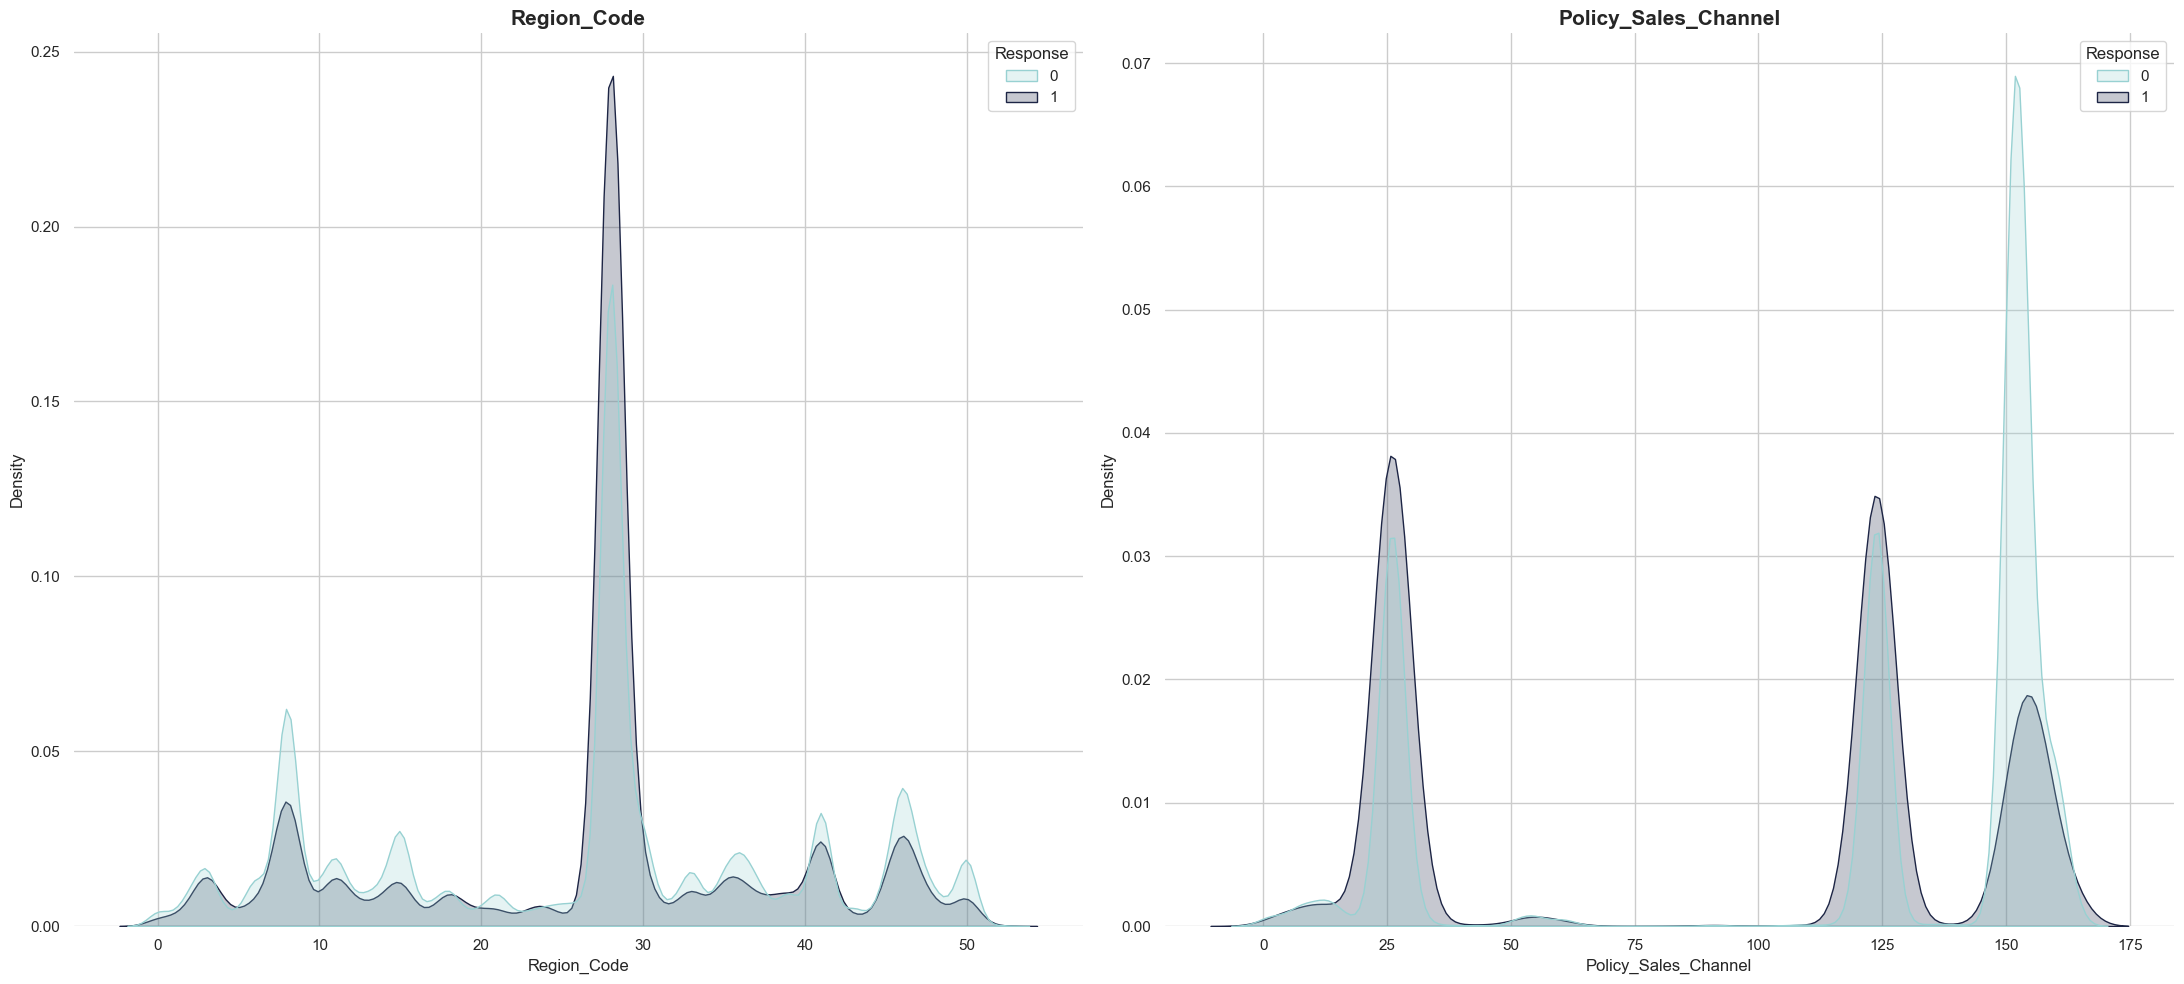

In [16]:
# Визуализация распределения признаков
numerical = ['Age', 'Annual_Premium', 'Vintage']
nominal = ['Driving_License' , 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel', 'Response', 'Gender', 'Vehicle_Age', 'Vehicle_Damage']

sns.set_theme(style="whitegrid")
#plt.style.use('ggplot')
cmap = sns.color_palette("ch:rot=-.25,hue=1,light=.75", 2)

# Числовые признаки
fig, axes = plt.subplots(2, 3, figsize=(22,12))
for i, num in enumerate(numerical):
    sns.boxplot(ax = axes[0][i], y = num, x = 'Response', data = df, hue = 'Response', palette = cmap)
    axes[0][i].set_xlabel(xlabel = 'Response', fontdict={'fontsize': 14})
    axes[0][i].set_ylabel(ylabel = num, fontdict={'fontsize': 14})
    axes[0][i].set_title(num, fontdict={'fontsize': 15,  'fontweight' :'bold'})

    sns.kdeplot(data = df, x = num, hue = "Response", fill = True, common_norm = False, ax = axes[1][i], palette = cmap)
    axes[1][i].set_xlabel(xlabel = num, fontdict={'fontsize': 14})
    axes[1][i].set_ylabel(ylabel = 'Density', fontdict={'fontsize': 14})
    axes[1][i].set_title(num, fontdict={'fontsize': 15,  'fontweight' :'bold'})

plt.suptitle('Чиловые признаки', fontsize = 22, fontweight = 'bold' )
sns.despine(bottom = True, left = True, right = True, top = True)
fig.tight_layout()
plt.show()

# Номинальные признаки
fig, axes = plt.subplots(2, 3, figsize=(22,10))
nrow = 0
ncol = 0
for i, nom in zip(axes.flatten(), ['Driving_License' , 'Previously_Insured', 'Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Response']):
    #if nom != 'Response':
    sns.countplot(x = df[nom], hue = df['Response'], ax = i, palette = cmap)
    #else: sns.countplot(x = df[nom], ax = i, palette = cmap)
    axes[nrow][ncol].set_title(nom, fontdict={'fontsize': 15,  'fontweight' :'bold'})
    if ncol < 2: ncol +=1 
    else:
        ncol = 0
        nrow += 1

plt.suptitle('\nКатегориальные признаки', fontsize = 22, fontweight = 'bold' )
sns.despine(bottom = True, left = True, right = True, top = True)
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(22,10))
for i, nom in enumerate(['Region_Code', 'Policy_Sales_Channel']):
    sns.kdeplot(data = df, x = nom, hue = "Response", fill = True, common_norm = False, ax = axes[i], palette = cmap)
    axes[i].set_title(nom, fontdict={'fontsize': 15,  'fontweight' :'bold'})

sns.despine(bottom = True, left = True, right = True, top = True)
fig.tight_layout()

plt.show()

In [14]:
# Закодируем оставшиеся категориальные признаки методом Label Encoding
gender = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(gender)

vehicle_age = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years':2}
df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age)

vehicle_damage = {'No': 0, 'Yes': 1}
df['Vehicle_Damage'] = df['Vehicle_Damage'].map(vehicle_damage)

In [15]:
# Описательная статистика с учетом закодированных признаков
df.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,4.585964e-01,3.838755e+01,9.980264e-01,2.641528e+01,4.628668e-01,6.032090e-01,5.028480e-01,3.046855e+04,1.124040e+02,1.639189e+02,1.230562e-01
std,4.982828e-01,1.499676e+01,4.438136e-02,1.298993e+01,4.986193e-01,5.678246e-01,4.999919e-01,1.647620e+04,5.404819e+01,7.997458e+01,3.285017e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,0.000000e+00,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.527900e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,0.000000e+00,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,1.000000e+00,1.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,1.000000e+00,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,3.945400e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.000000e+00,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,2.000000e+00,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [19]:
# Визуализация исходного набора - Проекция на главные компоненты
pca = PCA(n_components=3)
df_PCA = pca.fit_transform(df[[col for col in df.columns if col != 'Response']])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print('Доля объясненной дисперсии (нарастающим итогом)')
for i, j in enumerate(cumulative_variance):
  print(f'PCA {i+1} = {j:.5f}')

Доля объясненной дисперсии (нарастающим итогом)
PCA 1 = 0.99996
PCA 2 = 0.99999
PCA 3 = 1.00000


In [20]:
def plot_pca(X, y, ax, title):
    '''
    Функция визуализации проекции на главные компоненнты.
    '''
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c = y, cmap = "mako")
    ax.set_xlabel('PC 1', labelpad = 10)
    ax.set_ylabel('PC 2', labelpad = 10)
    ax.set_zlabel('PC 3', labelpad = 10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_box_aspect(None, zoom=0.8)
    if title is not None:
        ax.set_title(title)

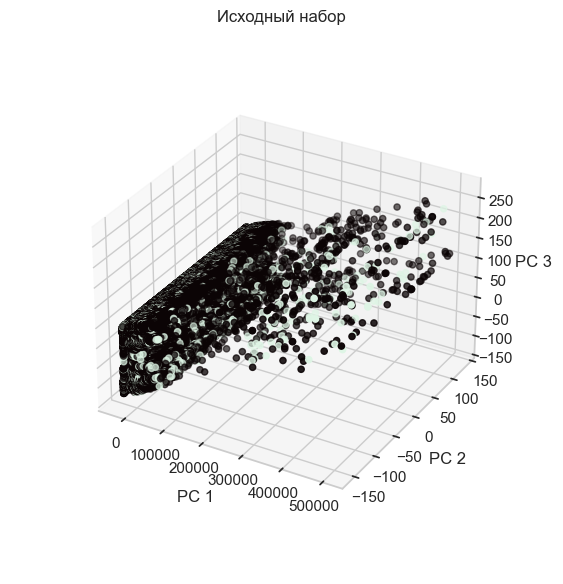

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection="3d")
plot_pca(df_PCA, df['Response'], ax, title = 'Исходный набор')
fig.tight_layout()

## Нормализация данных 

In [16]:
scaler = MinMaxScaler().fit(df)

# Сохраним обученный scaler
# with open('minmax_scaler.pkl', 'wb') as file:
#    pickle.dump(scaler, file)

df_sc = pd.DataFrame(scaler.transform(df), columns = df.columns)
df_sc.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,4.585964e-01,2.828855e-01,9.980264e-01,5.079862e-01,4.628668e-01,3.016045e-01,5.028480e-01,5.178929e-02,6.876789e-01,5.325915e-01,1.230562e-01
std,4.982828e-01,2.307194e-01,4.438136e-02,2.498064e-01,4.986193e-01,2.839123e-01,4.999919e-01,3.065139e-02,3.336308e-01,2.767287e-01,3.285017e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,6.153846e-02,1.000000e+00,2.884615e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.213493e-02,1.728395e-01,3.079585e-01,0.000000e+00
50%,0.000000e+00,2.461538e-01,1.000000e+00,5.384615e-01,0.000000e+00,5.000000e-01,1.000000e+00,5.431088e-02,9.259259e-01,5.397924e-01,0.000000e+00
75%,1.000000e+00,4.461538e-01,1.000000e+00,6.730769e-01,1.000000e+00,5.000000e-01,1.000000e+00,6.850531e-02,9.320988e-01,7.681661e-01,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [17]:
# Визуализация отскалированных данных 
# Проекция на главные компоненты

pca = PCA(n_components=3)
df_PCA = pca.fit_transform(df_sc[[col for col in df_sc.columns if col != 'Response']])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print('Доля объясненной дисперсии (нарастающим итогом)')
for i, j in enumerate(cumulative_variance):
  print(f'PCA {i+1} = {j:.5f}')

Доля объясненной дисперсии (нарастающим итогом)
PCA 1 = 0.44323
PCA 2 = 0.66051
PCA 3 = 0.78848


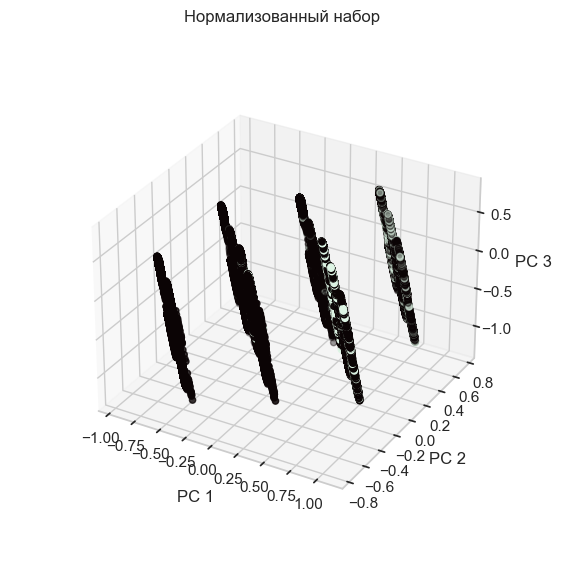

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection="3d")
plot_pca(df_PCA, df_sc['Response'], ax, title = 'Нормализованный набор')
fig.tight_layout()

# Создание и обучение моделей

In [18]:
# Разбиение выборки для кросс-валидации
kFold = StratifiedKFold(n_splits = 5, shuffle = False)

In [19]:
X = df_sc[[col for col in df_sc.columns if col != 'Response']]
y = df_sc['Response']

In [20]:
# Выделим категориальные признаки
X['Region_Code_cat'] = X['Region_Code'].astype('category')
X['Policy_Sales_Channel_cat'] = X['Policy_Sales_Channel'].astype('category')
X = X.drop(columns = ['Region_Code', 'Policy_Sales_Channel'])

## LightGBM Classifier

### Baseline Model

Для начала посмотрим на работу модели без применения любых стратегий для работы с дисбалансом классов.

In [21]:
# Создаем классификатор с параметрами по умолчанию
lgbm = LGBMClassifier(class_weight = 'balanced') # если не указано иначе, по умолчанию применяется градиентный бустинг boosting_type='gbdt'

In [22]:
# Подбираем лучшие параметры дла классификатора, максимизирующие метрику recall
params = {
    'n_estimators': [100, 150, 200],
    'learning_rate': np.arange(0.05, 0.2, step = 0.05),
    'min_data_in_leaf': np.arange(1, 10, 2),
    'subsample' : [0.6, 0.75, 0.8, 1],
    'colsample_bytree': [0.5, 0.75, 1]
         }

random_lgbm = RandomizedSearchCV(lgbm, params, cv = kFold, 
                          scoring = 'roc_auc', n_jobs = 7, n_iter = 10, random_state = 42, error_score = 'raise').fit(X, y)

print('Лучшие гиперпараметры модели:', random_lgbm.best_params_)
print(f'Лучший результат: {random_lgbm.best_score_:.4f}')

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Number of positive: 615281, number of negative: 4384719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 5000000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Лучшие гиперпараметры модели: {'subsample': 0.8, 'n_estimators': 150, 'min_data_in_leaf': np.int64(3), 'learning_rate': np.float64(0.2), 'colsample_bytree': 0.5}
Лучший результат: 0.8784


In [23]:
# Модель с лучшими параметрами
lgbm = LGBMClassifier (n_estimators = 150, learning_rate = 0.2,
                       min_data_in_leaf = 3,
                       subsample = 0.8,
                       colsample_bytree = 0.5,
                       random_seed = 42,
                       class_weight = 'balanced')

In [24]:
# Оценка других метрик для лучшего классификатора
res = [{'model': 'Baseline LGBM Gradient Boost'}]
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_metrics = cross_validate(lgbm, X, y, scoring = scoring, cv = kFold, n_jobs = 7)
for score in scoring:
    print(f'{score}: {np.mean(cv_metrics['test_' + score]):.4f} ({np.std(cv_metrics['test_' + score]):.4f})')
    res[0][score] = round(np.mean(cv_metrics['test_' + score]), 4)

accuracy: 0.7253 (0.0003)
precision: 0.3004 (0.0003)
recall: 0.9277 (0.0004)
f1: 0.4539 (0.0003)
roc_auc: 0.8782 (0.0003)


### Применение стратегий работы с дисбалансом классов

#### Random Oversampling

In [25]:
ros_pipeline = make_pipeline(RandomOverSampler(random_state = 42, sampling_strategy = 'minority'), 
                            LGBMClassifier(class_weight = 'balanced'))

In [26]:
params = {
    'lgbmclassifier__n_estimators': [100, 150, 200],
    'lgbmclassifier__learning_rate': np.arange(0.05, 0.2, step = 0.05),
    'lgbmclassifier__min_data_in_leaf': np.arange(1, 10, 2),
    'lgbmclassifier__subsample' : [0.6, 0.75, 0.8, 1],
    'lgbmclassifier__colsample_bytree': [0.5, 0.75, 1]
         }

In [27]:
random_lgbm = RandomizedSearchCV(ros_pipeline, params, cv = kFold, 
                          scoring = 'roc_auc', n_jobs = 7, n_iter = 10, random_state = 42, error_score = 'raise').fit(X, y)

print('\nЛучшие гиперпараметры модели:', random_lgbm.best_params_)
print(f'Лучший результат: {random_lgbm.best_score_:.4f}')

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Number of positive: 4384719, number of negative: 4384719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.316386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 8769438, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Лучшие гиперпараметры модели: {'lgbmclassifier__subsample': 0.8, 'lgbmclassifier__n_estimators': 150, 'lgbmclassifier__min_data_in_leaf': np.int64(3), 'lgbmclassifier__learning_rate': np.float64(0.2), 'lgbmclassifier__colsample_bytree': 0.5}
Лучший ре

In [28]:
# Модель с лучшими параметрами
lgbm = LGBMClassifier (n_estimators = 150, learning_rate = 0.2,
                       min_data_in_leaf = 3,
                       subsample = 0.8,
                       colsample_bytree = 0.5,
                       random_seed = 42,
                       class_weight = 'balanced')

In [29]:
ros_pipeline = make_pipeline(RandomOverSampler(random_state = 42, sampling_strategy = 'minority'), 
                            lgbm)

In [38]:
res.append({'model': 'Random Oversampling LGBM'})
cv_metrics = cross_validate(ros_pipeline, X, y, scoring = scoring, cv = kFold, n_jobs = 7)
for score in scoring:
    print(f'{score}: {np.mean(cv_metrics['test_' + score]):.4f} ({np.std(cv_metrics['test_' + score]):.4f})')
    res[len(res)-1][score] = round(np.mean(cv_metrics['test_' + score]), 4)

accuracy: 0.7246 (0.0003)
precision: 0.2999 (0.0002)
recall: 0.9279 (0.0005)
f1: 0.4533 (0.0003)
roc_auc: 0.8781 (0.0003)


#### Random Undersampling

In [31]:
rus_pipeline = make_pipeline(RandomUnderSampler(random_state = 42, sampling_strategy = 'majority'), 
                            LGBMClassifier(class_weight = 'balanced'))

In [32]:
random_lgbm = RandomizedSearchCV(rus_pipeline, params, cv = kFold, 
                          scoring = 'roc_auc', n_jobs = 7, n_iter = 15, random_state = 42, error_score = 'raise').fit(X, y)

print('\nЛучшие гиперпараметры модели:', random_lgbm.best_params_)
print(f'Лучший результат: {random_lgbm.best_score_:.4f}')

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Number of positive: 615281, number of negative: 615281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1230562, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Лучшие гиперпараметры модели: {'lgbmclassifier__subsample': 0.8, 'lgbmclassifier__n_estimators': 150, 'lgbmclassifier__min_data_in_leaf': np.int64(3), 'lgbmclassifier__learning_rate': np.float64(0.2), 'lgbmclassifier__colsample_bytree': 0.5}
Лучший резу

In [33]:
# Модель с лучшими параметрами
lgbm = LGBMClassifier (n_estimators = 150, learning_rate = 0.2,
                       min_data_in_leaf = 3,
                       subsample = 0.8,
                       colsample_bytree = 0.5,
                       random_seed = 42,
                       class_weight = 'balanced')

rus_pipeline = make_pipeline(RandomUnderSampler(random_state = 42, sampling_strategy = 'majority'), 
                            lgbm)

In [43]:
res.append({'model': 'Random Undersampling LGBM'})
cv_metrics = cross_validate(rus_pipeline, X, y, scoring = scoring, cv = kFold, n_jobs = 7)
for score in scoring:
    print(f'{score}: {np.mean(cv_metrics['test_' + score]):.4f} ({np.std(cv_metrics['test_' + score]):.4f})')
    res[len(res)-1][score] = round(np.mean(cv_metrics['test_' + score]), 4)

accuracy: 0.7242 (0.0010)
precision: 0.2997 (0.0007)
recall: 0.9283 (0.0008)
f1: 0.4531 (0.0007)
roc_auc: 0.8779 (0.0004)


#### SMOTE

In [39]:
#SMOTE_pipeline = make_pipeline(SMOTE(random_state = 42, sampling_strategy = 'minority'), 
#                            LGBMClassifier(class_weight = 'balanced'))

In [40]:
#random_lgbm = RandomizedSearchCV(SMOTE_pipeline, params, cv = kFold, 
#                          scoring = 'roc_auc', n_jobs = 4, n_iter = 5, random_state = 42, error_score='raise').fit(X, y)

#print('\nЛучшие гиперпараметры модели:', random_lgbm.best_params_)
#print(f'Лучший результат: {random_lgbm.best_score_:.4f}')

In [41]:
# Модель с лучшими параметрами
#lgbm = LGBMClassifier (n_estimators = 100, learning_rate = 0.2,
#                       min_data_in_leaf = 1,
#                       random_seed = 42,
#                       class_weight = 'balanced')
#SMOTE_pipeline = make_pipeline(SMOTE(random_state = 42, sampling_strategy = 'minority'), lgbm)

In [42]:
#res.append({'model': 'SMOTE LGBM'})
#for score in scoring:
#    print(f'{score}: {np.mean(cv_metrics['test_' + score]):.4f} ({np.std(cv_metrics['test_' + score]):.4f})')
#    res[len(res)-1][score] = round(np.mean(cv_metrics['test_' + score]), 4)

#### ADASYN

In [ ]:
#ADASYN_pipeline = make_pipeline(ADASYN(random_state = 42, sampling_strategy = 'minority'), 
#                            LGBMClassifier(class_weight = 'balanced'))

In [ ]:
# random_lgbm = RandomizedSearchCV(ADASYN_pipeline, params, cv = kFold, 
#                          scoring = 'roc_auc', n_jobs = 7, n_iter = 5, random_state = 42, error_score='raise').fit(X, y)

# print('\nЛучшие гиперпараметры модели:', random_lgbm.best_params_)
# print(f'Лучший результат: {random_lgbm.best_score_:.4f}')

In [ ]:
# Модель с лучшими параметрами
#lgbm = LGBMClassifier (n_estimators = 100, learning_rate = 0.1,
#                       min_data_in_leaf = 1,
#                       colsample_bytree = 0.5, # уменьшим кол-во признаков для обучения деревьев
#                       subsample = 0.7, # уменьшим размер выборки на которой обучаются деревья
#                       random_seed = 42,
#                       class_weight = 'balanced')
#ADASYN_pipeline = make_pipeline(ADASYN(random_state = 42, sampling_strategy = 'minority'), lgbm)

In [ ]:
#res.append({'model': 'ADASYN LGBM'})
#for score in scoring:
#    print(f'{score}: {np.mean(cv_metrics['test_' + score]):.4f} ({np.std(cv_metrics['test_' + score]):.4f})')
#    res[len(res)-1][score] = round(np.mean(cv_metrics['test_' + score]), 4)

#### Tomek Links

In [ ]:
#TOMEK_pipeline = make_pipeline(TomekLinks(sampling_strategy = 'majority', n_jobs = 7), 
#                            LGBMClassifier(class_weight = 'balanced'))

In [ ]:
#random_lgbm = RandomizedSearchCV(TOMEK_pipeline, params, cv = kFold, 
#                          scoring = 'roc_auc', n_jobs = 7, n_iter = 5, random_state = 42, error_score='raise').fit(X, y)

#print('\nЛучшие гиперпараметры модели:', random_lgbm.best_params_)
#print(f'Лучший результат: {random_lgbm.best_score_:.4f}')

In [ ]:
# Модель с лучшими параметрами
# lgbm = LGBMClassifier (n_estimators = 100, learning_rate = 0.2,
                    #    min_data_in_leaf = 1,
                    #    random_seed = 42,
                    #    class_weight = 'balanced')
# TOMEK_pipeline = make_pipeline(TomekLinks(sampling_strategy = 'majority', n_jobs = 7), lgbm)

In [ ]:
# res.append({'model': 'TomekLinks LGBM'})
# for score in scoring:
    # print(f'{score}: {np.mean(cv_metrics['test_' + score]):.4f} ({np.std(cv_metrics['test_' + score]):.4f})')
    # res[len(res)-1][score] = round(np.mean(cv_metrics['test_' + score]), 4)

#### SMOTE - Tomek Links

In [ ]:
# SMOTETomek_pipeline = make_pipeline(SMOTETomek(random_state = 42, sampling_strategy = 'minority', n_jobs = 7), 
                            # LGBMClassifier(class_weight = 'balanced'))

In [ ]:
# random_lgbm = RandomizedSearchCV(SMOTETomek_pipeline, params, cv = kFold, 
                        #   scoring = 'roc_auc', n_jobs = 7, n_iter = 5, random_state = 42, error_score='raise').fit(X, y)

# print('\nЛучшие гиперпараметры модели:', random_lgbm.best_params_)
# print(f'Лучший результат: {random_lgbm.best_score_:.4f}')

In [ ]:
# Модель с лучшими параметрами
# lgbm = LGBMClassifier (n_estimators = 100, learning_rate = 0.1,
                    #    min_data_in_leaf = 1,
                    #    random_seed = 42,
                    #    class_weight = 'balanced')
# SMOTETomek_pipeline = make_pipeline(SMOTETomek(random_state = 42, sampling_strategy = 'minority', n_jobs = 7), lgbm)

In [ ]:
#res.append({'model': 'SMOTE - Tomek Links LGBM'})
# for score in scoring:
    # print(f'{score}: {np.mean(cv_metrics['test_' + score]):.4f} ({np.std(cv_metrics['test_' + score]):.4f})')
    # res[len(res)-1][score] = round(np.mean(cv_metrics['test_' + score]), 4)

### Результаты обучения моделей

In [47]:
res = [{'model' : 'Baseline LGBM GradientBoost',
        'accuracy': 0.7253,
        'precision': 0.3004,
        'recall': 0.9277,
        'f1': 0.4539,
        'roc_auc': 0.8782}, 
       {'model': 'Random Oversampling LGBM',
        'accuracy': 0.7246,
        'precision': 0.2999,
        'recall': 0.9279,
        'f1': 0.4533,
        'roc_auc': 0.8781}, 
       {'model': 'Random Undersampling LGBM',
        'accuracy': 0.7242,
        'precision': 0.2997,
        'recall': 0.9283,
        'f1': 0.4531,
        'roc_auc': 0.8779}]

In [48]:
results =  pd.DataFrame(res)
results

,model,accuracy,precision,recall,f1,roc_auc
0,Baseline LGBM GradientBoost,0.7253,0.3004,0.9277,0.4539,0.8782
1,Random Oversampling LGBM,0.7246,0.2999,0.9279,0.4533,0.8781
2,Random Undersampling LGBM,0.7242,0.2997,0.9283,0.4531,0.8779
